In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import mode

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

pd.options.mode.chained_assignment = None

In [16]:
raw = pd.read_csv('tr_eikon_eod_data.csv', 
                 index_col = 0, parse_dates = True)
print(raw.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB
None


In [17]:
colnames = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']
tickers = ["AAPL", "MSFT", "INTC", "AMZN", "GS"]

In [18]:
ext_data = yf.download("AAPL MSFT INTC AMZN GS", start="2010-01-01", end="2018-07-01")

print(ext_data.info())

[*********************100%%**********************]  5 of 5 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  2138 non-null   float64
 1   (Adj Close, AMZN)  2138 non-null   float64
 2   (Adj Close, GS)    2138 non-null   float64
 3   (Adj Close, INTC)  2138 non-null   float64
 4   (Adj Close, MSFT)  2138 non-null   float64
 5   (Close, AAPL)      2138 non-null   float64
 6   (Close, AMZN)      2138 non-null   float64
 7   (Close, GS)        2138 non-null   float64
 8   (Close, INTC)      2138 non-null   float64
 9   (Close, MSFT)      2138 non-null   float64
 10  (High, AAPL)       2138 non-null   float64
 11  (High, AMZN)       2138 non-null   float64
 12  (High, GS)         2138 non-null   float64
 13  (High, INTC)       2138 non-null   float64
 14  (High, MSFT)       2138 non-null   float64
 15  (Low, AAPL)        2138 non-null   float64
 16  (Low, 

In [19]:
data = raw[colnames]

print(ext_data["Open"]["AAPL"])
print(ext_data["Close"]["AAPL"])
print(ext_data["High"]["AAPL"])
print(ext_data["Low"]["AAPL"])
print(data["AAPL.O"])
print(data[data.isna().any(axis=1)])
print(ext_data["Close"])

rets = pd.DataFrame()

for stock in colnames:
    data[f"{stock} ret"] = np.log(data[stock] / data[stock].shift(1))

data.dropna(inplace=True)    

for stock in colnames:
    data[f"{stock} dir"] = np.sign(data[f"{stock} ret"]).astype(int)

Date
2010-01-04     7.622500
2010-01-05     7.664286
2010-01-06     7.656429
2010-01-07     7.562500
2010-01-08     7.510714
                ...    
2018-06-25    45.849998
2018-06-26    45.747501
2018-06-27    46.307499
2018-06-28    46.025002
2018-06-29    46.572498
Name: AAPL, Length: 2138, dtype: float64
Date
2010-01-04     7.643214
2010-01-05     7.656429
2010-01-06     7.534643
2010-01-07     7.520714
2010-01-08     7.570714
                ...    
2018-06-25    45.542500
2018-06-26    46.107498
2018-06-27    46.040001
2018-06-28    46.375000
2018-06-29    46.277500
Name: AAPL, Length: 2138, dtype: float64
Date
2010-01-04     7.660714
2010-01-05     7.699643
2010-01-06     7.686786
2010-01-07     7.571429
2010-01-08     7.571429
                ...    
2018-06-25    46.230000
2018-06-26    46.632500
2018-06-27    46.820000
2018-06-28    46.552502
2018-06-29    46.797501
Name: AAPL, Length: 2138, dtype: float64
Date
2010-01-04     7.585000
2010-01-05     7.616071
2010-01-06     7.

In [20]:
stock_bins = {}

for stock in colnames:
    mean = data[f'{stock} ret'].mean()
    std = data[f'{stock } ret'].std()
    stock_bins[stock] = [mean - std, mean, mean + std]

lag_feat = []
for stock in colnames:
    for i in range(1,6):
        feat = f'{stock} lag_' + str(i)
        data[feat] = np.digitize(data[f'{stock} ret'].shift(i), stock_bins[stock])
        lag_feat.append(feat)

data

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,AAPL.O ret,MSFT.O ret,INTC.O ret,AMZN.O ret,GS.N ret,...,AMZN.O lag_1,AMZN.O lag_2,AMZN.O lag_3,AMZN.O lag_4,AMZN.O lag_5,GS.N lag_1,GS.N lag_2,GS.N lag_3,GS.N lag_4,GS.N lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,30.625684,30.960,20.87,134.690,176.14,0.001727,0.000323,-0.000479,0.005883,0.017525,...,3,3,3,3,3,3,3,3,3,3
2010-01-06,30.138541,30.770,20.80,132.250,174.26,-0.016034,-0.006156,-0.003360,-0.018282,-0.010731,...,2,3,3,3,3,3,3,3,3,3
2010-01-07,30.082827,30.452,20.60,130.000,177.67,-0.001850,-0.010389,-0.009662,-0.017160,0.019379,...,1,2,3,3,3,1,3,3,3,3
2010-01-08,30.282827,30.660,20.83,133.520,174.31,0.006626,0.006807,0.011103,0.026717,-0.019093,...,1,1,2,3,3,3,1,3,3,3
2010-01-11,30.015684,30.270,20.95,130.308,171.56,-0.008861,-0.012802,0.005744,-0.024350,-0.015902,...,3,1,1,2,3,0,3,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.170000,98.390,50.71,1663.150,221.54,-0.014983,-0.020323,-0.034690,-0.031090,-0.020020,...,1,1,2,2,2,1,1,1,1,1
2018-06-26,184.430000,99.080,49.67,1691.090,221.58,0.012330,0.006988,-0.020722,0.016660,0.000181,...,0,1,1,2,2,0,1,1,1,1
2018-06-27,184.160000,97.540,48.76,1660.510,220.18,-0.001465,-0.015665,-0.018491,-0.018249,-0.006338,...,2,0,1,1,2,2,0,1,1,1


In [21]:
def calculate_rsi(prices, period=14):
    deltas = prices.diff()
    gains = deltas.where(deltas > 0, 0)
    losses = -deltas.where(deltas < 0, 0)
    
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

rsi_bins = {}

for stock in colnames:
    feat = f"{stock} rsi"
    data[feat] = calculate_rsi(data[stock])
    mean = data[feat].mean()
    std = data[feat].std()
    rsi_bins[stock] = [mean - std, mean, mean + std]
    
    data[feat] = data[feat].shift(1)

rsi_feat = [f"{stock} rsi"]

In [22]:
sma_windows = [3, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 200, 250]

for stock in colnames:
    for i in sma_windows:
        data[f"{stock} SMA {i}"] = data[stock].rolling(window=i).mean().shift(1)

C:\Users\chaos\AppData\Local\Temp\ipykernel_3988\3597553836.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{stock} SMA {i}"] = data[stock].rolling(window=i).mean().shift(1)


In [23]:
def moving_average(data, window_short=10, window_long=250):
    """
    Calculate short-term and long-term moving averages.

    Parameters:
    - data: List or array-like object containing the time series data.
    - window_short: Integer specifying the window size for the short-term moving average.
    - window_long: Integer specifying the window size for the long-term moving average.

    Returns:
    - short_ma: List containing the short-term moving averages.
    - long_ma: List containing the long-term moving averages.
    """

    # Calculate short-term moving average
    short_ma = data.rolling(window=window_short).mean()

    # Calculate long-term moving average
    long_ma = data.rolling(window=window_long).mean()

    return short_ma, long_ma

for stock in colnames:
    short, long = moving_average(data[f"{stock} ret"])
    data[f'{stock} ret SMA'] = np.where(short > long, 1, -1)
    data[f"{stock} ret SMA"] = data[f"{stock} ret SMA"].shift(1)

ma_feat = [f"{stock} ret SMA" for stock in colnames]


C:\Users\chaos\AppData\Local\Temp\ipykernel_3988\41212074.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{stock} ret SMA'] = np.where(short > long, 1, -1)
C:\Users\chaos\AppData\Local\Temp\ipykernel_3988\41212074.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{stock} ret SMA'] = np.where(short > long, 1, -1)
C:\Users\chaos\AppData\Local\Temp\ipykernel_3988\41212074.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

In [24]:
def simple_sma_trade(data, window=20):
    sma = data.rolling(window=window).mean()
    return np.where(data > sma, 1, -1)

for stock in colnames:
    data[f"{stock} SMA trade"] = simple_sma_trade(data[stock])
    data[f"{stock} SMA trade"] = data[f"{stock} SMA trade"].shift(1)

sma_feat = [f"{stock} SMA trade" for stock in colnames]

C:\Users\chaos\AppData\Local\Temp\ipykernel_3988\4052058623.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{stock} SMA trade"] = simple_sma_trade(data[stock])
C:\Users\chaos\AppData\Local\Temp\ipykernel_3988\4052058623.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{stock} SMA trade"] = simple_sma_trade(data[stock])
C:\Users\chaos\AppData\Local\Temp\ipykernel_3988\4052058623.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

In [25]:
feat_data = data.dropna()

for stock in colnames:
    feat = f"{stock} digi-rsi"
    rsi = f"{stock} rsi"
    feat_data[feat] = np.digitize(feat_data[rsi], bins=rsi_bins[stock])
    feat_data[feat + "-1"] = np.digitize(feat_data[rsi], bins=[30, 70])
    feat_data[feat + "-2"] = np.digitize(feat_data[rsi], bins=[20, 80])
    feat_data[f'{stock} SMA'] = np.where(feat_data[f"{stock} SMA 20"] > feat_data[f"{stock} SMA 50"], 1, -1)

ma_feat = [f"{stock} SMA" for stock in colnames]

In [26]:
def print_data(string, data):
    print("-" * 100)
    print(string)
    print("-" * 100)
    print(data)

----------------------------------------------------------------------------------------------------
Returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.876553
MSFT.O ret    1.010421
INTC.O ret    0.931353
AMZN.O ret    1.251008
GS.N ret      0.661118
dtype: float64
----------------------------------------------------------------------------------------------------
RandomForest returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.832190
MSFT.O ret    1.023669
INTC.O ret    0.716301
AMZN.O ret    1.447357
GS.N ret      0.764249
dtype: float64
----------------------------------------------------------------------------------------------------
False predictions:
----------------------------------------------------------------------------------------------------
AAPL.O dir    189
MSFT.O dir    184
INTC.O dir    195
AMZN.O dir    177
GS.N dir    

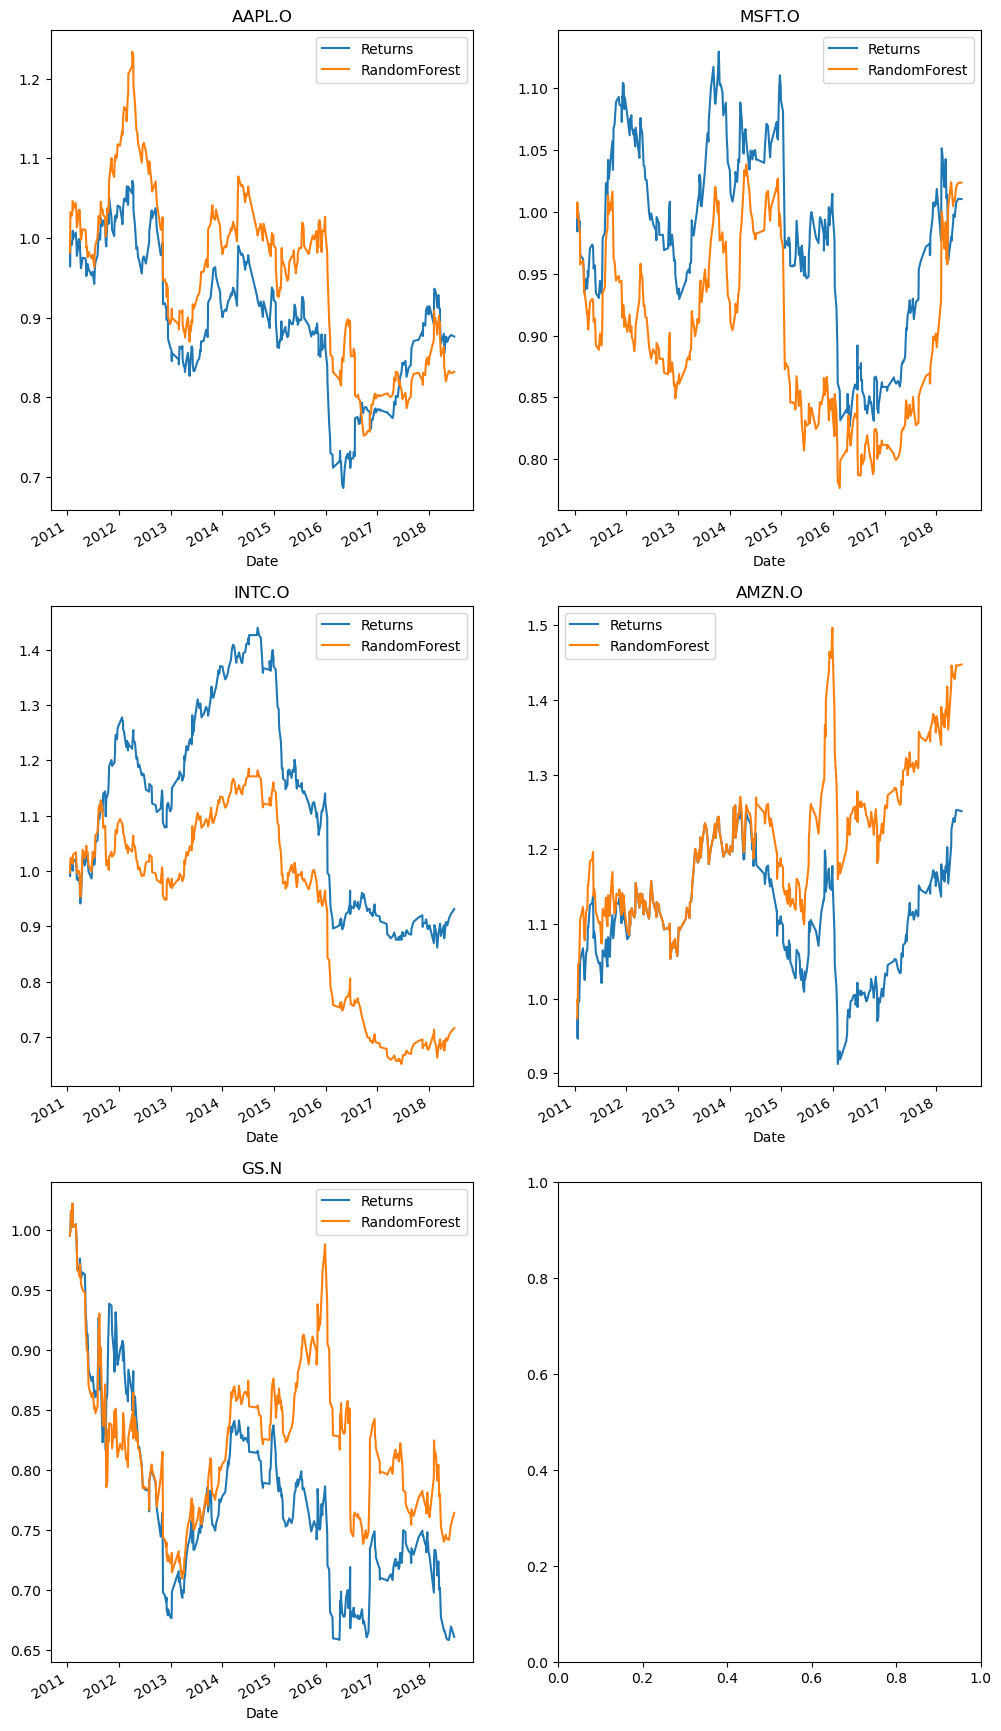

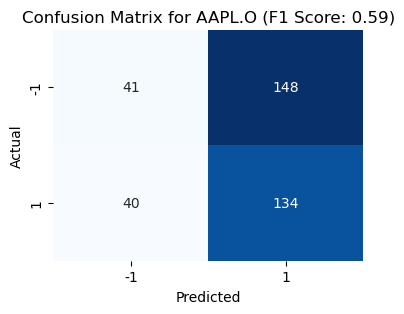

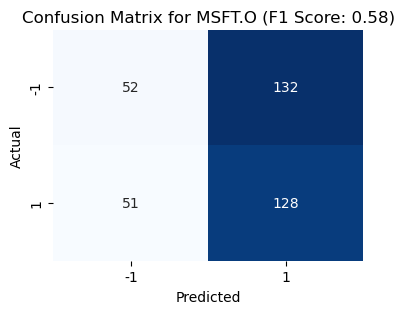

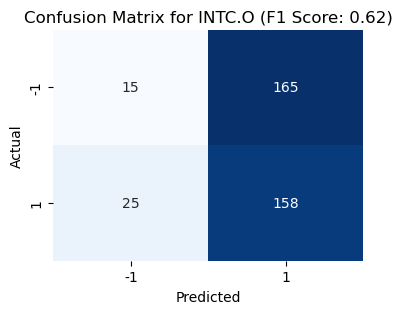

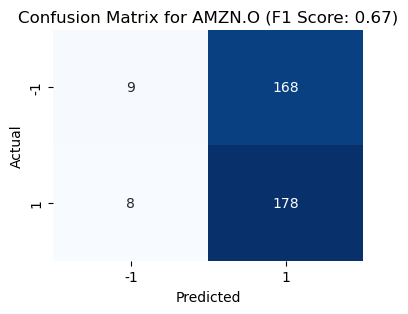

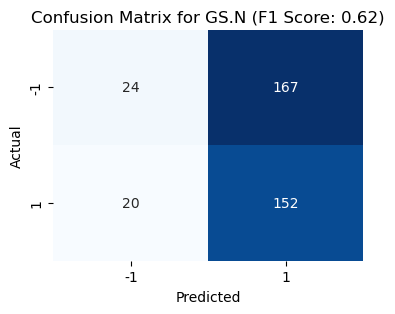

[[ 1  1  1  1  1]
 [-1 -1 -1 -1  1]
 [ 1 -1  1  1  1]
 ...
 [ 1  1  1  1  1]
 [-1  1  1  1  1]
 [-1 -1  1 -1 -1]]


In [27]:
data_train, data_test = train_test_split(feat_data, 
                                         test_size = 0.2,
                                         random_state = 0)
features = ma_feat + sma_feat + lag_feat# + [f"{stock} ret SMA" for stock in colnames]

# test_split = len(data) // 5

# data_train = feat_data[:- test_split]
# data_test = feat_data[-test_split:]

data_train = data_train.copy().sort_index()
data_test = data_test.copy().sort_index()

training = data_train[features]
testing = data_test[features]

training_res = data_train[[f"{stock} dir" for stock in colnames]]
testing_res = data_test[[f"{stock} dir" for stock in colnames]]

model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)

model.fit(training, training_res)

results = model.predict(testing)

print_data("Returns:", data_test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp))

print_data("RandomForest returns:", (results * data_test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp))

print_data("False predictions:", (results != data_test[[f"{stock} dir" for stock in colnames]]).sum())

print_data("Total rows:", results.shape[0])

feature_importances = model.feature_importances_
print_data("Feature importance:", pd.DataFrame(data=feature_importances, index=features, columns=["Importance"]).sort_values("Importance", ascending=False))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,24))

for i, stock in enumerate(colnames):
    data_test[f"{stock} ret"].cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="returns")
    (results[:,i] * data_test[f"{stock} ret"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="RandomForest")

    # (data_test[f"{stock} ret"] * data_test[f"{stock} dir"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="Optimal")
    
    axes[i // 2, i % 2].legend(["Returns", "RandomForest"])
    axes[i // 2, i % 2].set_title(stock)

def calculate_f1_score(conf_matrix):
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return f1_score

# Iterate over each column and create confusion matrix
for i, stock in enumerate(colnames):
    # Create confusion matrix
    conf_matrix = np.zeros((2, 2))
    for actual, predicted in zip(data_test[f"{stock} dir"].values, results[:, i]):
        actual_index = 0 if actual == -1 else 1
        predicted_index = 0 if predicted == -1 else 1
        conf_matrix[actual_index, predicted_index] += 1

    # Calculate F1 score
    f1_score = calculate_f1_score(conf_matrix)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {stock} (F1 Score: {f1_score:.2f})')
    plt.show()

print(results)



In [28]:
def simulate_model(it, data=feat_data, train=data_train, test=data_test, ran_split=False, feat=features, rerun=0, rolling_parse=1):
    sim = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
    improv = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
    false_pred = np.zeros((it * (1 + rerun), 5))
    f1s = np.zeros((it * (1 + rerun), 5))
    imp = pd.DataFrame(index=feat)
    run = 0

    while True:
        if ran_split:
            train, test = train_test_split(data, 
                                                test_size = 0.2)

        training = train[feat]
        testing = test[feat]

        for i in range(it):
            model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)
            model.fit(training, training_res)

            results = model.predict(testing)
            results = pd.DataFrame(data=results).rolling(window=rolling_parse, min_periods=1).apply(lambda x: mode(x)[0])
            rets = test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp)
            pred_rets = (results * test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp)

            sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

            improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
            false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in colnames]]).sum()

            importances = pd.Series(model.feature_importances_, index=training.columns)
            imp = pd.concat([imp, importances], axis=1)

            for j, stock in enumerate(colnames):
                # Create confusion matrix
                conf_matrix = np.zeros((2, 2))
                for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
                    actual_index = 0 if actual == -1 else 1
                    predicted_index = 0 if predicted == -1 else 1
                    conf_matrix[actual_index, predicted_index] += 1

                # Calculate F1 score
                f1_score = calculate_f1_score(conf_matrix)
                f1s[i + run * it, j] = f1_score
        run += 1
        if run <= rerun:
            continue
        else:
            break

    false_pred = pd.DataFrame(data=false_pred, columns=[stock for stock in colnames], index=[j for j in range(it * (1 + rerun))])

    sorted_imp = (imp.sum(axis=1) / (it * (1 + rerun))).sort_values(ascending=False)

    print_data("Mean improvement: ", sim.mean())

    print_data("std dev of improvements: ", sim.std())

    print_data("Number of improvements: ", improv.replace(-1, 0).sum(axis=0))

    print_data("Mean false predictions: ", false_pred.mean())

    print_data("std dev false predictions: ", false_pred.std())

    print_data("Mean feature importance", sorted_imp)

    print_data("std dev feature importance", imp.std(axis=1).reindex(sorted_imp.index))

    print_data("Mean f1 score:", pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1" for stock in colnames]))

    print_data("std dev of f1 scores: ", pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1" for stock in colnames]))

In [29]:
itr = 100
reruns = 50
ran_split = True

In [30]:
simulate_model(itr, ran_split=ran_split, rerun=reruns)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AAPL.O ret   -0.104636
MSFT.O ret   -0.084292
INTC.O ret   -0.082699
AMZN.O ret   -0.088511
GS.N ret      0.005341
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.303747
MSFT.O ret    0.375357
INTC.O ret    0.192518
AMZN.O ret    0.318997
GS.N ret      0.250555
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    1834
MSFT.O ret    2133
INTC.O ret    1664
AMZN.O 

In [31]:
rsi_feat = [f"{stock} rsi" for stock in colnames]

simulate_model(itr, feat=(features + rsi_feat), ran_split=ran_split, rerun=reruns)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AAPL.O ret   -0.091006
MSFT.O ret   -0.108631
INTC.O ret   -0.032509
AMZN.O ret   -0.121497
GS.N ret     -0.003067
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.311271
MSFT.O ret    0.329779
INTC.O ret    0.225978
AMZN.O ret    0.326285
GS.N ret      0.242128
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    1930
MSFT.O ret    1774
INTC.O ret    2202
AMZN.O 

In [32]:
digi_rsi_feat = [f"{stock} digi-rsi" for stock in colnames]

simulate_model(itr, feat=(features + digi_rsi_feat), ran_split=ran_split, rerun=reruns)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AAPL.O ret   -0.113320
MSFT.O ret   -0.061493
INTC.O ret   -0.070557
AMZN.O ret   -0.073534
GS.N ret      0.053310
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.284966
MSFT.O ret    0.396953
INTC.O ret    0.220502
AMZN.O ret    0.316645
GS.N ret      0.282863
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    1754
MSFT.O ret    2106
INTC.O ret    1842
AMZN.O 

In [33]:
digi_rsi_feat = [f"{stock} digi-rsi-1" for stock in colnames]

simulate_model(itr, feat=(features + digi_rsi_feat), ran_split=ran_split, rerun=reruns)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AAPL.O ret   -0.203172
MSFT.O ret   -0.213684
INTC.O ret   -0.115021
AMZN.O ret   -0.147766
GS.N ret     -0.010217
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.337091
MSFT.O ret    0.319972
INTC.O ret    0.215119
AMZN.O ret    0.405044
GS.N ret      0.279235
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    1314
MSFT.O ret    1295
INTC.O ret    1462
AMZN.O 

In [34]:
digi_rsi_feat = [f"{stock} digi-rsi-2" for stock in colnames]

simulate_model(itr, feat=(features + digi_rsi_feat), ran_split=ran_split, rerun=reruns)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AAPL.O ret   -0.138050
MSFT.O ret   -0.178734
INTC.O ret   -0.054767
AMZN.O ret   -0.093482
GS.N ret      0.027474
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.329528
MSFT.O ret    0.333270
INTC.O ret    0.207196
AMZN.O ret    0.311717
GS.N ret      0.256151
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    1602
MSFT.O ret    1496
INTC.O ret    1904
AMZN.O 

## Fine-tuning

Below are some codes used to finetune the features

### Fine-tuning: SMA short and long

In [35]:
# table = pd.DataFrame()
# it = 100
# rerun = 15
# ran_split = True
# feat = features + [f"{stock} digi-rsi" for stock in colnames]

# for n in range(len(sma_windows)):
#     for m in range(n + 1,len(sma_windows)):
#         label = f"{sma_windows[n]} and {sma_windows[m]}"

#         feat_data[f'{stock} SMA'] = np.where(feat_data[f"{stock} SMA {sma_windows[n]}"] > feat_data[f"{stock} SMA {sma_windows[m]}"], 1, -1)
            
#         sim = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#         improv = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#         false_pred = np.zeros((it * (1 + rerun), 5))
#         f1s = np.zeros((it * (1 + rerun), 5))
#         imp = pd.DataFrame(index=feat)
#         run = 0

#         while True:
#             if ran_split:
#                 train, test = train_test_split(feat_data, 
#                                                     test_size = 0.2)

#             training = train[feat]
#             testing = test[feat]

#             for i in range(it):
#                 model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)
#                 model.fit(training, training_res)

#                 results = model.predict(testing)
#                 rets = test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp)
#                 pred_rets = (results * test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp)

#                 sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

#                 improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
#                 false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in colnames]]).sum()

#                 importances = pd.Series(model.feature_importances_, index=training.columns)
#                 imp = pd.concat([imp, importances], axis=1)

#                 for j, stock in enumerate(colnames):
#                     # Create confusion matrix
#                     conf_matrix = np.zeros((2, 2))
#                     for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
#                         actual_index = 0 if actual == -1 else 1
#                         predicted_index = 0 if predicted == -1 else 1
#                         conf_matrix[actual_index, predicted_index] += 1

#                     # Calculate F1 score
#                     f1_score = calculate_f1_score(conf_matrix)
#                     f1s[i + run * it, j] = f1_score
#             run += 1
#             if run <= rerun:
#                 continue
#             else:
#                 break

#         false_pred = pd.DataFrame(data=false_pred, columns=[f"{stock} falses" for stock in colnames], index=[j for j in range(it * (1 + rerun))])

#         imp_mean = (imp.sum(axis=1) / (it * (1 + rerun)))
#         imp_mean.index = [f"{imp} mean imp" for imp in feat]

#         ret_mean = sim.mean()
#         ret_mean.index = [f"{stock} mean ret" for stock in colnames]

#         print(improv)
#         improv.columns = [f"{stock} improvs" for stock in colnames]

#         summary = pd.concat([ret_mean, 
#                              sim.std(), 
#                              improv.replace(-1, 0).sum(axis=0), 
#                              false_pred.mean(), false_pred.std(), 
#                              imp_mean, 
#                              imp.std(axis=1), 
#                              pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1 mean" for stock in colnames]), 
#                              pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1 std" for stock in colnames])], 
#                              axis=0)
#         summary.columns = [label]

#         table = pd.concat([table, summary.T], axis=0)

In [36]:
# opt_ratios = []

# for stock in colnames:
#     opt_ratios.append(table.sort_values(by=f"{stock} mean ret", ascending=False).head(10))
#     opt_ratios.append(table.sort_values(by=f"{stock} improvs", ascending=False).head(10))

# for i in opt_ratios:
#     print("-" * 100)
#     print("-" * 100)
#     print(i)

In [37]:
# table.to_csv("grid_search.csv", sep=',')